# Firstly check the dataset by plotting

Num of points: 42


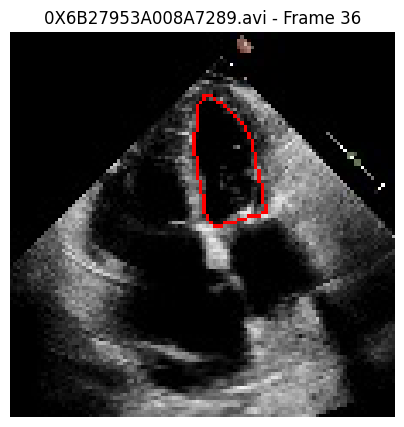

Num of points: 42


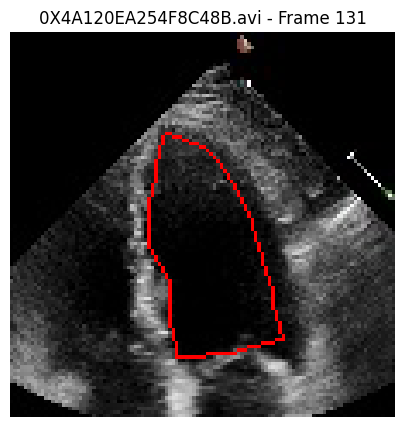

Num of points: 42


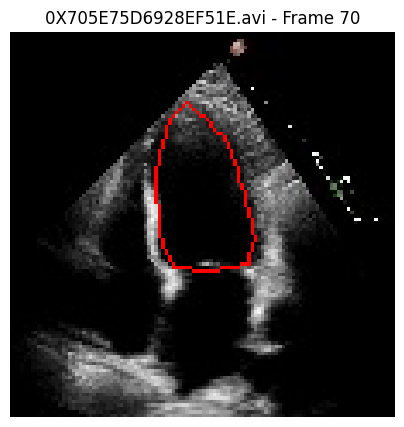

Num of points: 42


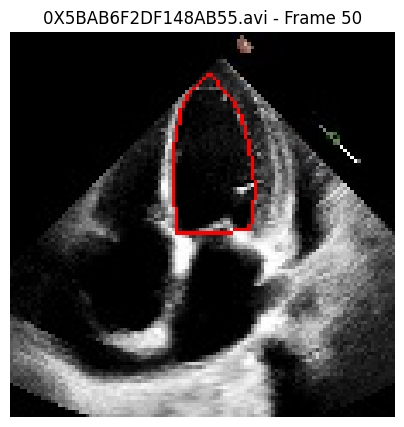

Num of points: 42


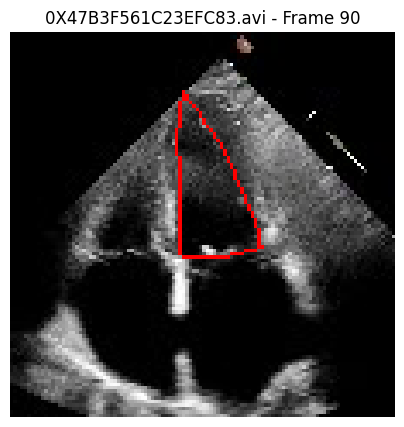

In [ ]:
import os
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths (adjust if needed)
csv_path = "../data/EchoNet-Dynamic/VolumeTracings.csv"
video_dir = "../data/EchoNet-Dynamic/Videos/"  # directory containing .avi files

# Load CSV
df = pd.read_csv(csv_path)

# Group by video name and frame
grouped = df.groupby(["FileName", "Frame"])

# Pick N random (video, frame) pairs
N = 5
random_samples = random.sample(list(grouped.groups.keys()), N)

# Plotting
for i, (filename, frame) in enumerate(random_samples):
    # Load video frame
    video_path = os.path.join(video_dir, filename)
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    ret, img = cap.read()
    cap.release()
    
    if not ret:
        print(f"Failed to load frame {frame} from {filename}")
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get all points for this frame
    points = grouped.get_group((filename, frame))[["X1", "Y1", "X2", "Y2"]].values
    # Convert to list of (x, y) points
    polygon_points = []
    for x1, y1, x2, y2 in points:
        polygon_points.append((x1, y1))
    for x1, y1, x2, y2 in reversed(points):
        polygon_points.append((x2, y2))

    # Draw polygon
    print(f'Num of points: {len(polygon_points)}')
    # Combine all keypoints
    points = grouped.get_group((filename, frame))[["X1", "Y1", "X2", "Y2"]].values
    polygon_points = np.vstack([points[:, :2], points[:, 2:]])

    # Calculate centroid
    center = np.mean(polygon_points, axis=0)

    # Sort points based on angle from center
    angles = np.arctan2(polygon_points[:, 1] - center[1], polygon_points[:, 0] - center[0])
    sorted_idx = np.argsort(angles)
    sorted_points = polygon_points[sorted_idx]

    # Convert to integer coordinates
    sorted_points = np.array(sorted_points, dtype=np.int32)

    # Draw polygon
    cv2.polylines(img, [sorted_points], isClosed=True, color=(255, 0, 0), thickness=1)




    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"{filename} - Frame {frame}")
    plt.axis("off")
    plt.show()


# Create the datasets for YOLO Pose estimation and the regressor

In [9]:
import os
import cv2
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np

In [10]:
# ==== Config ====
MAX_KEYPOINTS = 50
OUTPUT_DIR = Path("../data/yolo_keypoints_dataset")
REGR_CSV_PATH = Path("../data/regressor_dataset.csv")
VIDEO_DIR = Path("../data/EchoNet-Dynamic/Videos")
for split in ['train', 'val', 'test']:
    os.makedirs(OUTPUT_DIR / split / "images", exist_ok=True)
    os.makedirs(OUTPUT_DIR / split / "labels", exist_ok=True)

In [11]:

# ==== Load CSVs ====
filelist_df = pd.read_csv("../data/EchoNet-Dynamic/FileList.csv")
volume_df = pd.read_csv("../data/EchoNet-Dynamic/VolumeTracings.csv")

In [12]:
print(filelist_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10030 entries, 0 to 10029
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FileName        10030 non-null  object 
 1   EF              10030 non-null  float64
 2   ESV             10030 non-null  float64
 3   EDV             10030 non-null  float64
 4   FrameHeight     10030 non-null  int64  
 5   FrameWidth      10030 non-null  int64  
 6   FPS             10030 non-null  int64  
 7   NumberOfFrames  10030 non-null  int64  
 8   Split           10030 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 705.4+ KB
None


In [13]:
print(volume_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425010 entries, 0 to 425009
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FileName  425010 non-null  object 
 1   X1        425010 non-null  float64
 2   Y1        425010 non-null  float64
 3   X2        425010 non-null  float64
 4   Y2        425010 non-null  float64
 5   Frame     425010 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 19.5+ MB
None


In [14]:
print("Sample video_id from volume_df:", volume_df['FileName'].iloc[0])
print("Sample VideoBase from volume_df:", volume_df['FileName'].iloc[0].replace('.avi', ''))

print("Sample FileName from filelist_df:", filelist_df['FileName'].iloc[0])


Sample video_id from volume_df: 0X100009310A3BD7FC.avi
Sample VideoBase from volume_df: 0X100009310A3BD7FC
Sample FileName from filelist_df: 0X100009310A3BD7FC


In [15]:
from scipy.interpolate import interp1d

# Preprocessing
filelist_df['FileName'] = filelist_df['FileName'].str.strip()
volume_df['VideoBase'] = volume_df['FileName'].str.replace('.avi', '', regex=False)
volume_df['Frame'] = volume_df['Frame'].astype(int)
grouped = volume_df.groupby(['VideoBase', 'Frame'])

print(f"Total grouped video-frame pairs: {len(grouped)}")

video_frame_areas = {}
regressor_entries = []

for (video_id, frame_num), group in tqdm(grouped, desc="Processing", unit="frame"):
    split_row = filelist_df[filelist_df['FileName'] == f"{video_id}"]
    if split_row.empty:
        print(f"Video ID not found in FileList.csv: {video_id}")
        continue

    split = split_row['Split'].values[0]
    esv = split_row['ESV'].values[0]
    edv = split_row['EDV'].values[0]

    out_img_dir = OUTPUT_DIR / split.lower() / "images"
    out_lbl_dir = OUTPUT_DIR / split.lower() / "labels"
    out_img_dir.mkdir(parents=True, exist_ok=True)
    out_lbl_dir.mkdir(parents=True, exist_ok=True)

    video_path = VIDEO_DIR / f"{video_id}.avi"
    if not video_path.exists():
        print(f"Missing video: {video_path}")
        continue

    # Read frame
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print(f"Could not read frame {frame_num} from {video_id}")
        continue
    h, w = frame.shape[:2]

    out_img_path = out_img_dir / f"{video_id}_f{frame_num}.jpg"
    cv2.imwrite(str(out_img_path), frame)

    # Extract and combine points
    points = group[["X1", "Y1", "X2", "Y2"]].values
    polygon_points = np.vstack([points[:, :2], points[:, 2:]]).astype(np.float32)

    # Sort by angle around centroid
    center = np.mean(polygon_points, axis=0)
    angles = np.arctan2(polygon_points[:, 1] - center[1], polygon_points[:, 0] - center[0])
    sorted_idx = np.argsort(angles)
    polygon_points = polygon_points[sorted_idx]

    # Interpolate or truncate to exactly 42 points
    if len(polygon_points) < 42:
        # Interpolate using linear interpolation
        idxs = np.linspace(0, len(polygon_points) - 1, num=42)
        interp_x = interp1d(np.arange(len(polygon_points)), polygon_points[:, 0], kind='linear')(idxs)
        interp_y = interp1d(np.arange(len(polygon_points)), polygon_points[:, 1], kind='linear')(idxs)
        abs_points = np.stack([interp_x, interp_y], axis=-1)
    else:
        abs_points = polygon_points[:42]

    # Area
    area = cv2.contourArea(abs_points.astype(np.int32))
    if video_id not in video_frame_areas:
        video_frame_areas[video_id] = []
    video_frame_areas[video_id].append({
        'frame': frame_num,
        'area': area,
        'esv': esv,
        'edv': edv
    })

    # Normalize for YOLO label
    norm_points = [(x / w, y / h) for x, y in abs_points]
    keypoints_flat = [coord for point in norm_points for coord in point]

    out_lbl_path = out_lbl_dir / f"{video_id}_f{frame_num}.txt"
    with open(out_lbl_path, 'w') as f:
        f.write("0 " + " ".join(f"{kp:.6f}" for kp in keypoints_flat) + "\n")

# Generate regressor dataset from max/min area frames
for video_id, frames in video_frame_areas.items():
    if len(frames) == 0:
        continue
    max_entry = max(frames, key=lambda f: f['area'])
    min_entry = min(frames, key=lambda f: f['area'])

    regressor_entries.append({
        'video_id': video_id,
        'frame_num': max_entry['frame'],
        'area': max_entry['area'],
        'volume_type': 'esv',
        'volume_value': max_entry['esv']
    })
    regressor_entries.append({
        'video_id': video_id,
        'frame_num': min_entry['frame'],
        'area': min_entry['area'],
        'volume_type': 'edv',
        'volume_value': min_entry['edv']
    })

# Save regressor dataset
regressor_df = pd.DataFrame(regressor_entries)
regressor_df.to_csv(REGR_CSV_PATH, index=False)
print(f"Regressor dataset saved to: {REGR_CSV_PATH}")


Total grouped video-frame pairs: 20050


Processing:  53%|█████▎    | 10674/20050 [10:44<08:40, 18.02frame/s] 

Video ID not found in FileList.csv: 0X4F8859C8AB4DA9CB
Video ID not found in FileList.csv: 0X4F8859C8AB4DA9CB


Processing: 100%|██████████| 20050/20050 [21:25<00:00, 15.59frame/s]


Regressor dataset saved to: ../data/regressor_dataset.csv


In [16]:
regressor_df.shape

(20048, 5)

In [17]:
volume_df.head()

,FileName,X1,Y1,X2,Y2,Frame,VideoBase
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46,0X100009310A3BD7FC
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46,0X100009310A3BD7FC
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46,0X100009310A3BD7FC
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46,0X100009310A3BD7FC
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46,0X100009310A3BD7FC


In [18]:
# Group by unique frames (VideoBase + Frame)
grouped = volume_df.groupby(["VideoBase", "Frame"])

# Count number of keypoints per frame
keypoints_per_frame = grouped.size()

# Compute stats
min_kp = keypoints_per_frame.min()
max_kp = keypoints_per_frame.max()
mean_kp = keypoints_per_frame.mean()
median_kp = keypoints_per_frame.median()

# Print the stats
print(f"Min keypoints per frame: {min_kp}")
print(f"Max keypoints per frame: {max_kp}")
print(f"Mean keypoints per frame: {mean_kp:.2f}")
print(f"Median keypoints per frame: {median_kp}")

Min keypoints per frame: 16
Max keypoints per frame: 168
Mean keypoints per frame: 21.20
Median keypoints per frame: 21.0


# Check the YOLO and Volume based regression Dataset

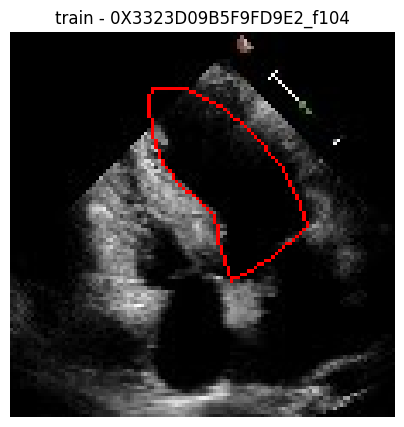

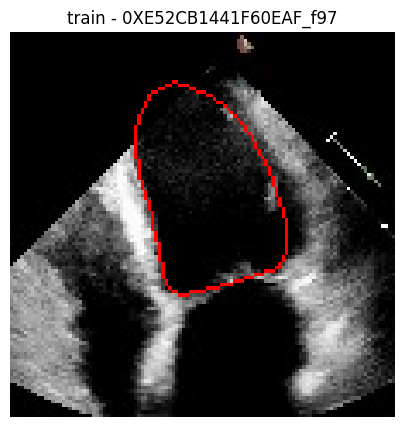

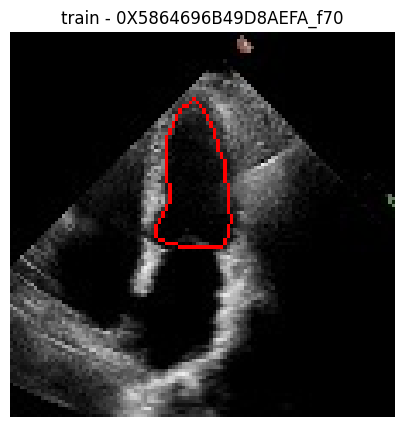

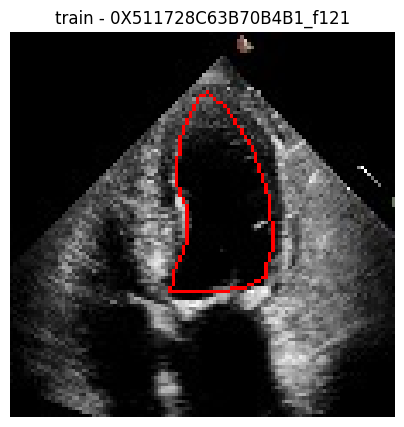

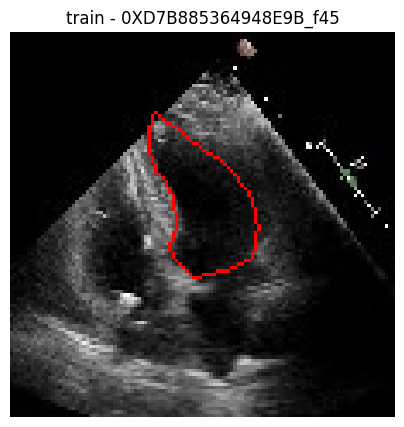

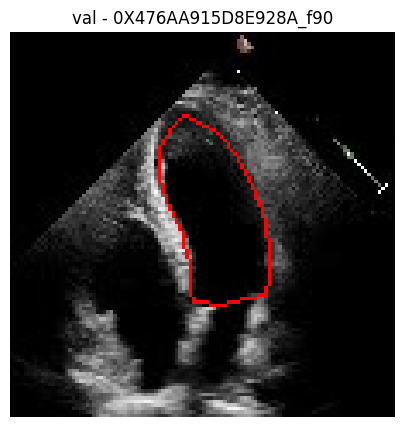

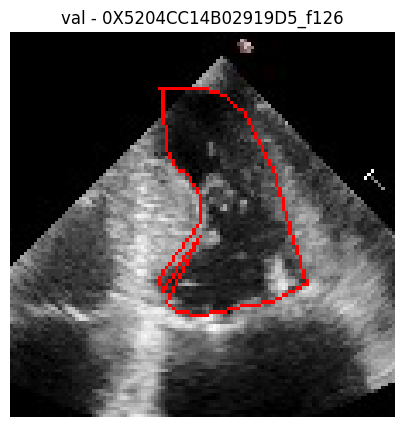

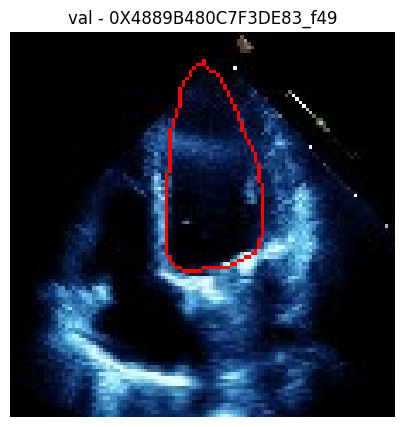

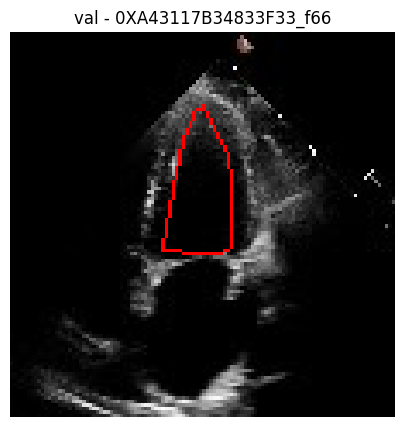

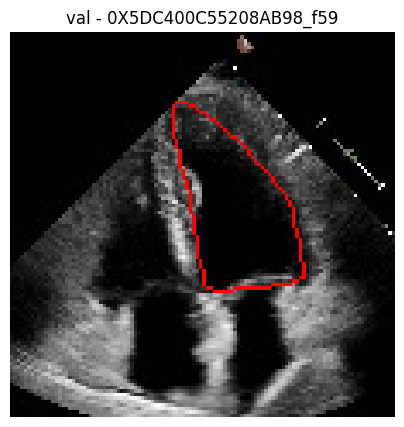

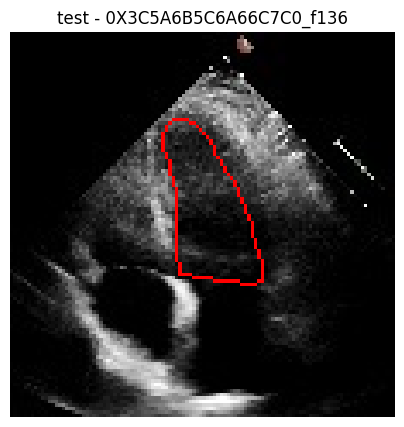

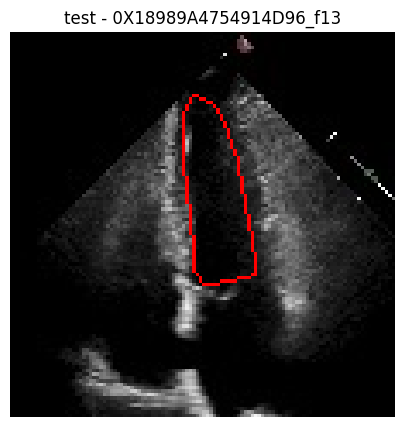

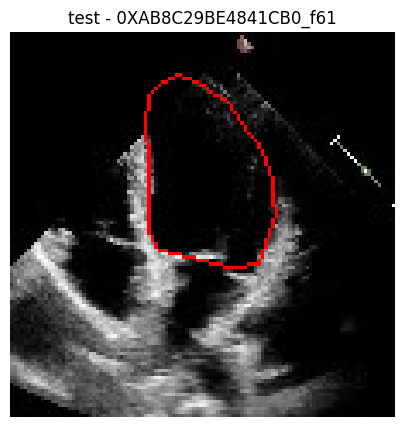

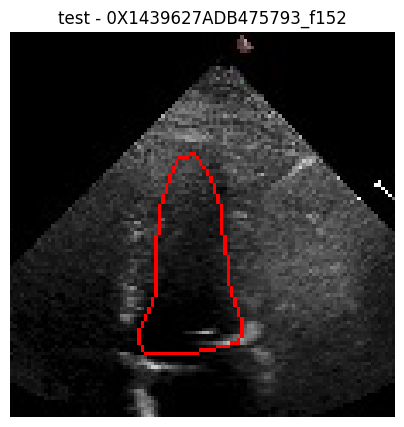

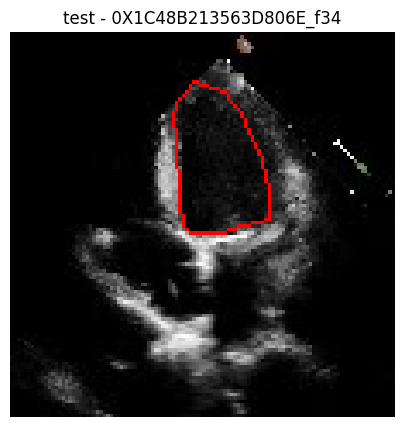

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Config
YOLO_DATA_DIR = Path("../data/yolo_keypoints_dataset/")  # Structure: train/images, train/labels, etc.
SPLITS = ["train", "val", "test"]
NUM_SAMPLES = 5
MAX_KPTS = 40  # Must match your YOLO label format

for split in SPLITS:
    img_dir = YOLO_DATA_DIR / split / "images"
    lbl_dir = YOLO_DATA_DIR / split / "labels"

    all_images = sorted(list(img_dir.glob("*.jpg")))
    samples = random.sample(all_images, min(NUM_SAMPLES, len(all_images)))

    for img_path in samples:
        label_path = lbl_dir / f"{img_path.stem}.txt"
        if not label_path.exists():
            print(f"Label not found: {label_path}")
            continue

        # Load image
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Read YOLO keypoints from label
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            if not line or len(line) < 2 * MAX_KPTS + 1:
                print(f"Incomplete keypoints in {label_path}")
                continue
            keypoints = list(map(float, line[1:]))

        # Reshape and filter valid keypoints
        keypoints = np.array(keypoints).reshape(-1, 2)
        valid_kpts = keypoints[(keypoints[:, 0] >= 0) & (keypoints[:, 1] >= 0)]
        if len(valid_kpts) < 3:
            print(f"Not enough valid keypoints in {label_path}")
            continue

        # Denormalize to image dimensions
        abs_kpts = np.stack([valid_kpts[:, 0] * w, valid_kpts[:, 1] * h], axis=1)

        # Sort points to form polygon
        center = np.mean(abs_kpts, axis=0)
        angles = np.arctan2(abs_kpts[:, 1] - center[1], abs_kpts[:, 0] - center[0])
        sorted_idx = np.argsort(angles)
        sorted_kpts = abs_kpts[sorted_idx].astype(np.int32)

        # Draw polygon
        cv2.polylines(img, [sorted_kpts], isClosed=True, color=(255, 0, 0), thickness=1)

        # Show
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"{split} - {img_path.stem}")
        plt.axis("off")
        plt.show()


# Create the CNN Regression Dataset

In [3]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import json

# Paths
VIDEO_DIR = Path("../data/EchoNet-Dynamic/Videos")
REGRESSOR_CSV = Path("../data/regressor_dataset.csv")
OUTPUT_ESV = Path("../data/cnn_dataset/esv")
OUTPUT_EDV = Path("../data/cnn_dataset/edv")

# Create output dirs
OUTPUT_ESV.mkdir(parents=True, exist_ok=True)
OUTPUT_EDV.mkdir(parents=True, exist_ok=True)

# Load CSV
df = pd.read_csv(REGRESSOR_CSV)

# Function to extract frame
def extract_frame(video_path, frame_number):
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    cap.release()
    if success:
        return frame
    return None

# Store metadata
esv_data = []
edv_data = []

# Process each row
for _, row in tqdm(df.iterrows(), total=len(df)):
    video_id = row["video_id"]
    frame_num = int(row["frame_num"])
    area = float(row["area"])
    volume = float(row["volume_value"])
    vol_type = row["volume_type"].lower()

    video_path = VIDEO_DIR / f"{video_id}.avi"
    frame = extract_frame(video_path, frame_num)
    if frame is None:
        continue

    # Save frame image
    out_dir = OUTPUT_ESV if vol_type == "esv" else OUTPUT_EDV
    out_img_path = out_dir / f"{video_id}_f{frame_num}.jpg"
    cv2.imwrite(str(out_img_path), frame)

    # Optionally, load YOLO keypoints
    label_path = Path(f"../data/yolo_keypoint_dataset/train/labels/{video_id}_f{frame_num}.txt")
    if not label_path.exists():
        label_path = Path(f"../data/yolo_keypoint_dataset/val/labels/{video_id}_f{frame_num}.txt")
    if not label_path.exists():
        label_path = Path(f"../data/yolo_keypoint_dataset/test/labels/{video_id}_f{frame_num}.txt")
    
    keypoints = None
    if label_path.exists():
        with open(label_path, "r") as f:
            parts = f.read().strip().split()
            if len(parts) >= 4:
                keypoints = list(map(float, parts[2:]))  # skip class + center x/y

    data_entry = {
        "video_id": video_id,
        "frame_num": frame_num,
        "area": area,
        "volume": volume,
        "image_path": str(out_img_path),
        "keypoints": keypoints
    }

    if vol_type == "esv":
        esv_data.append(data_entry)
    else:
        edv_data.append(data_entry)

# Save metadata
with open(OUTPUT_ESV / "metadata.json", "w") as f:
    json.dump(esv_data, f, indent=2)

with open(OUTPUT_EDV / "metadata.json", "w") as f:
    json.dump(edv_data, f, indent=2)

f"Done. ESV samples: {len(esv_data)}, EDV samples: {len(edv_data)}"



  0%|          | 0/20048 [00:00<?, ?it/s]

100%|██████████| 20048/20048 [05:28<00:00, 60.97it/s]


'Done. ESV samples: 10024, EDV samples: 10024'

In [5]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.interpolate import interp1d
from tqdm import tqdm

# Paths
volume_tracings_path = Path("../data/EchoNet-Dynamic/VolumeTracings.csv")
esv_metadata_path = Path("../data/cnn_dataset/esv/metadata.json")
edv_metadata_path = Path("../data/cnn_dataset/edv/metadata.json")

# Load volume tracings
volume_df = pd.read_csv(volume_tracings_path)
volume_df['VideoBase'] = volume_df['FileName'].str.replace('.avi', '', regex=False)
volume_df['Frame'] = volume_df['Frame'].astype(int)

# Build lookup: (video_id, frame_num) → polygon points
grouped = volume_df.groupby(['VideoBase', 'Frame'])
polygon_lookup = {}

for (video_id, frame_num), group in tqdm(grouped, desc="Building keypoint lookup"):
    points = group[["X1", "Y1", "X2", "Y2"]].values
    polygon_points = np.vstack([points[:, :2], points[:, 2:]]).astype(np.float32)

    # Sort polygon points around centroid
    center = np.mean(polygon_points, axis=0)
    angles = np.arctan2(polygon_points[:, 1] - center[1], polygon_points[:, 0] - center[0])
    sorted_idx = np.argsort(angles)
    polygon_points = polygon_points[sorted_idx]

    # Interpolate to 40 keypoints (20 pairs)
    if len(polygon_points) < 40:
        idxs = np.linspace(0, len(polygon_points) - 1, num=40)
        interp_x = interp1d(np.arange(len(polygon_points)), polygon_points[:, 0], kind='linear')(idxs)
        interp_y = interp1d(np.arange(len(polygon_points)), polygon_points[:, 1], kind='linear')(idxs)
        abs_points = np.stack([interp_x, interp_y], axis=-1)
    else:
        abs_points = polygon_points[:40]

    keypoints_flat = abs_points.flatten().tolist()
    polygon_lookup[(video_id, frame_num)] = keypoints_flat

# Function to update metadata list
def update_metadata(metadata_path):
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    updated = 0
    for entry in metadata:
        key = (entry["video_id"], entry["frame_num"])
        if key in polygon_lookup:
            entry["keypoints"] = polygon_lookup[key]
            updated += 1

    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    return updated

# Update both ESV and EDV
esv_updated = update_metadata(esv_metadata_path)
edv_updated = update_metadata(edv_metadata_path)

print(f"Updated keypoints: ESV = {esv_updated}, EDV = {edv_updated}")


Building keypoint lookup: 100%|██████████| 20050/20050 [00:14<00:00, 1414.24it/s]


Updated keypoints: ESV = 10024, EDV = 10024


# Create the joint esv edv dataset for resnet

In [8]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.interpolate import interp1d
import cv2

# ─── CONFIG ────────────────────────────────────────────────────────────────────

VIDEO_DIR          = Path("../data/EchoNet-Dynamic/Videos")
VOLUMETRACINGS_CSV = Path("../data/EchoNet-Dynamic/VolumeTracings.csv")
FILELIST_CSV       = Path("../data/EchoNet-Dynamic/FileList.csv")
OUTPUT_ROOT        = Path("../data/joint_esv_edv_dataset")

# ─── PREPARE OUTPUT DIRS ───────────────────────────────────────────────────────

for split in ("train","val","test"):
    (OUTPUT_ROOT/split/"images").mkdir(parents=True, exist_ok=True)

# ─── LOAD CSVs ─────────────────────────────────────────────────────────────────

volume_df   = pd.read_csv(VOLUMETRACINGS_CSV)
filelist_df = pd.read_csv(FILELIST_CSV)

filelist_df['VideoBase'] = filelist_df['FileName'].str.replace('.avi', '', regex=False)
filelist_df['Split']     = filelist_df['Split'].str.lower()

# ─── INDEX VOLUME TRACINGS ─────────────────────────────────────────────────────

volume_df['VideoBase'] = volume_df['FileName'].str.replace('.avi', '', regex=False)
volume_df['Frame']     = volume_df['Frame'].astype(int)
grouped_keys = list(volume_df.groupby(['VideoBase','Frame']).groups.keys())

# ─── KEYPOINTS & AREA UTIL ─────────────────────────────────────────────────────

def process_keypoints(group, target_pts=40):
    pts = group[["X1","Y1","X2","Y2"]].values
    if pts.size == 0: 
        return None, None

    poly = np.vstack([pts[:,:2], pts[:,2:]]).astype(np.float32)
    poly = np.unique(poly, axis=0)
    if len(poly) < 3:
        return None, None

    c = poly.mean(axis=0)
    ang = np.arctan2(poly[:,1]-c[1], poly[:,0]-c[0])
    poly = poly[np.argsort(ang)]

    if len(poly) < target_pts:
        xi = np.linspace(0, len(poly)-1, target_pts)
        x  = interp1d(np.arange(len(poly)), poly[:,0], kind='linear')(xi)
        y  = interp1d(np.arange(len(poly)), poly[:,1], kind='linear')(xi)
        poly = np.stack([x,y],axis=-1)
    else:
        poly = poly[:target_pts]

    contour = poly.astype(np.int32).reshape(-1,1,2)
    area    = cv2.contourArea(contour)
    return poly.flatten().tolist(), float(area)

# ─── MAIN LOOP ────────────────────────────────────────────────────────────────

metadata = {"train":[], "val":[], "test":[]}
skipped = 0

print("Building joint ESV/EDV dataset…")
for _, row in tqdm(filelist_df.iterrows(), total=len(filelist_df)):
    vid   = row['VideoBase']
    split = row['Split']
    if split not in metadata:
        split = 'train'

    # collect all frames for this video
    frames = [f for (v,f) in grouped_keys if v == vid]
    if len(frames) < 2:
        skipped += 1
        continue

    # compute (frame,area) pairs
    frame_areas = []
    for f in frames:
        group = volume_df[(volume_df['VideoBase']==vid)&(volume_df['Frame']==f)]
        _, area = process_keypoints(group)
        if area is not None:
            frame_areas.append((f,area))
    if len(frame_areas) < 2:
        skipped += 1
        continue

    # pick min=ESV, max=EDV
    esv_f, _ = min(frame_areas, key=lambda x:x[1])
    edv_f, _ = max(frame_areas, key=lambda x:x[1])

    # extract, save, metadata
    for label, frame_num in (("esv",esv_f),("edv",edv_f)):
        group = volume_df[(volume_df['VideoBase']==vid)&(volume_df['Frame']==frame_num)]
        kp, area = process_keypoints(group)
        if kp is None:
            skipped += 1
            continue

        cap = cv2.VideoCapture(str(VIDEO_DIR/f"{vid}.avi"))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ok, img = cap.read(); cap.release()
        if not ok:
            skipped += 1
            continue

        name = f"{vid}_{label}_f{frame_num}.jpg"
        path = OUTPUT_ROOT/split/"images"/name
        cv2.imwrite(str(path), img)

        metadata[split].append({
            "video_id": vid,
            "frame_num": int(frame_num),
            "label": label,
            "image_path": str(path.relative_to(OUTPUT_ROOT)),
            "keypoints": kp,
            "area": area
        })

# ─── SAVE METADATA ────────────────────────────────────────────────────────────

for split in ("train","val","test"):
    with open(OUTPUT_ROOT/split/"metadata.json","w") as f:
        json.dump(metadata[split], f, indent=2)
    print(f"{split.upper()}: {len(metadata[split])} samples")

print(f"Skipped {skipped} videos (missing frames/keypoints).")


Building joint ESV/EDV dataset…


100%|██████████| 10030/10030 [34:52<00:00,  4.79it/s] 


TRAIN: 14920 samples
VAL: 2576 samples
TEST: 2552 samples
Skipped 6 videos (missing frames/keypoints).


In [9]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd

# Load the current metadata.json files
root = Path("../data/joint_esv_edv_dataset")
splits = ["train", "val", "test"]

# Load FileList.csv to get ESV/EDV values
filelist_df = pd.read_csv("../data/EchoNet-Dynamic/FileList.csv")
filelist_df["VideoBase"] = filelist_df["FileName"].str.replace(".avi", "", regex=False)
filelist_df = filelist_df.set_index("VideoBase")

# Load and update metadata.json for each split
for split in splits:
    meta_path = root / split / "metadata.json"
    if not meta_path.exists():
        continue

    with open(meta_path) as f:
        data = json.load(f)

    # group by video_id
    videos = defaultdict(dict)
    for item in data:
        videos[item["video_id"]][item["label"]] = item

    # fill in volume for esv and edv
    new_data = []
    for vid, items in videos.items():
        if "esv" in items and "edv" in items:
            try:
                volumes = filelist_df.loc[vid]
                items["esv"]["volume"] = float(volumes["ESV"])
                items["edv"]["volume"] = float(volumes["EDV"])
                new_data.extend([items["esv"], items["edv"]])
            except Exception:
                pass  # skip if volumes are missing

    # save updated metadata.json
    with open(meta_path, "w") as f:
        json.dump(new_data, f, indent=2)

new_data[:2]  # Show sample updated metadata entries


[{'video_id': '0X100CF05D141FF143',
  'frame_num': 148,
  'label': 'esv',
  'image_path': 'test/images/0X100CF05D141FF143_esv_f148.jpg',
  'keypoints': [52.24835205078125,
   44.02554702758789,
   52.28801727294922,
   41.40742874145508,
   52.32768630981445,
   38.78931427001953,
   52.242679595947266,
   36.199317932128906,
   51.9073600769043,
   33.66578674316406,
   51.57203674316406,
   31.132251739501953,
   51.236717224121094,
   28.598718643188477,
   50.901397705078125,
   26.065185546875,
   50.542930603027344,
   23.53687286376953,
   50.53125,
   22.640625,
   51.65385818481445,
   23.286287307739258,
   54.2636604309082,
   25.306779861450195,
   56.90370178222656,
   27.320451736450195,
   59.60385513305664,
   29.32056427001953,
   61.75630569458008,
   31.444217681884766,
   63.3864631652832,
   33.68568420410156,
   65.01661682128906,
   35.927146911621094,
   65.94012451171875,
   38.328006744384766,
   66.7169189453125,
   40.761962890625,
   67.49370574951172,
   4